# gw2 2:3 Bifurcation Diagrams

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path to lib folder
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import gw2

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d, 
get_period, bif1d, follow_phase_diffs, phase_lock_r3d, follow_locking_3d)

from lib.rhs import _redu_3dc_gw as _redu_3dc

from lib.rhs import _redu_c,_full
from lib.plot_util import add_diagram_1d_scatter, quick_plot_combined

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-8,'atol':1e-8,'method':'LSODA'}

In [3]:
pd1 = {'v1':.84,'v2':.42,'v4':.35,'v6':.35,'v8':1,
           'k1':1,'k2':1,'k3':.7,'k4':1,'k5':.7,
           'k6':1,'k7':.35,'k8':1,'K':0.5,'kc':1,
           'n':6,'L':0,'eps':0,'del':0,'om':1,'om_fix':1}

In [4]:
kws1 = {'var_names':['x','y','z','v'],
        'pardict':pd1,
        'rhs':gw2.rhs,
        'coupling':gw2.coupling,
        'init':np.array([.3882,.523,1.357,.4347,24.2]),
        'TN':10000,
        'trunc_order':3,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':0.5}

## Defs

In [5]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [6]:
eps_list23r = np.linspace(0.001,.1,50)
etup23 = (.001,.1,50)

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

## Initialize Response Functions

In [8]:
system1 = rsp(idx=0,model_name='gw0',**kws1)
system2 = rsp(idx=1,model_name='gw1',**kws1)

mkdir ./data/gw0/
* Loading LC data...
self.T 6.283185307179586 omfix 3.8590183230656914
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975489297
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/gw1/
* Loading LC data...
self.T 6.283185307179586 omfix 3.8590183230656914
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975489297
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [9]:
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',2),'_m':('om1',3),
         'NH':2048,'save_fig':False}

# del=0.0

In [10]:
del23_p0 = 0
a23_p0 = nm.nmCoupling(**kw_nm, del1=del23_p0)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


## Get Branches Full

In [11]:
kw_p0 = {'a':a23_p0,'del1':del23_p0,'recompute':False,
         'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [12]:
data_p0_list = []

In [13]:
in_dicts = [dict(init=0,eps_init=0.1,eps_final=0.009,deps=-.01),
           dict(init=0,eps_init=0.01,eps_final=0.0005,deps=-.001)]

In [14]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0)
    data_p0_list.append(dat)
fname = kw_p0['bifdir']+'hyper_gw2_23_p0.txt'

fname1 td_branch_init=0_nm=23_del=0_ei=0.1_ef=0.009_de=-0.01.txt
fname2 ts_branch_init=0_nm=23_del=0_ei=0.1_ef=0.009_de=-0.01.txt
fname1 td_branch_init=0_nm=23_del=0_ei=0.01_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=23_del=0_ei=0.01_ef=0.0005_de=-0.001.txt


In [15]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [16]:
data_r3d_p0_list = []

In [17]:
# find init for this branch
_,init = phase_lock_r3d([1,0,0],a23_p0,.05,_redu_3dc)
print(init)

t_diff 0.93273362224547058, Y=[ 0.93273362 -0.03996297 -0.03986881]                                              
[ 0.9327 -0.04   -0.0399]


In [18]:
# bot 1f
dat = follow_locking_3d(init,a23_p0,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [19]:
# bot 1b
dat = follow_locking_3d(init,a23_p0,(.05,.001,-.001),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [20]:
# find init for this branch
_,init = phase_lock_r3d([3,0,0],a23_p0,.05,_redu_3dc)

t_diff 3.03137975020480089, Y=[ 3.03137975 -0.0402512  -0.04013373]                                              


In [21]:
# top 1f
dat = follow_locking_3d(init,a23_p0,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [22]:
# top 1b
dat = follow_locking_3d(init,a23_p0,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [23]:
# find init for this branch
_,init = phase_lock_r3d([5,0,0],a23_p0,.05,_redu_3dc)

t_diff 5.13256991563534555, Y=[ 5.13256992 -0.0402558  -0.04030459]                                              


In [24]:
# top 1f
dat = follow_locking_3d(init,a23_p0,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [25]:
# top 1b
dat = follow_locking_3d(init,a23_p0,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

## Plot

eps_min 0.03000000000000004


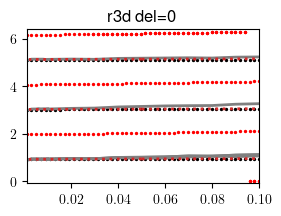

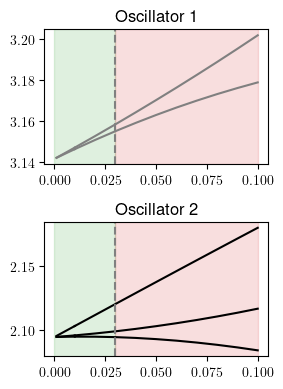

In [26]:
quick_plot_combined(a23_p0,
                    kw_f={'data_list':data_p0_list},
                    kw_r3d={'data_list':data_r3d_p0_list},
                    kw_r={'etup':etup23})

# del=0.002

In [27]:
del23_p002 = 0.002
a23_p002 = nm.nmCoupling(**kw_nm, del1=del23_p002)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


## Get Branches Full

In [28]:
kw_p002 = {'a':a23_p002, 'del1':del23_p002, 'recompute':False, 
           'bifdir':'bif1d_gw2/', '_full_rhs':_full}

In [29]:
data_p002_list = []

In [30]:
in_dicts = [dict(init=0,eps_init=0.01,eps_final=0.11,deps=.01),
            dict(init=0,eps_init=0.01, eps_final=0.0005,deps=-.001)]

In [31]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p002)
    data_p002_list.append(dat)
fname = kw_p002['bifdir']+'hyper_gw2_23_p002.txt'

fname1 td_branch_init=0_nm=23_del=0.002_ei=0.01_ef=0.11_de=0.01.txt
fname2 ts_branch_init=0_nm=23_del=0.002_ei=0.01_ef=0.11_de=0.01.txt
fname1 td_branch_init=0_nm=23_del=0.002_ei=0.01_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=23_del=0.002_ei=0.01_ef=0.0005_de=-0.001.txt


In [32]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [33]:
data_r3d_p002_list = []

In [34]:
# find init for this branch
_,init = phase_lock_r3d([1,0,0],a23_p002,.05,_redu_3dc)
print(init)

t_diff 1.08838597635694861, Y=[ 1.08838598 -0.05401809 -0.04356699]                                              
[ 1.0884 -0.054  -0.0436]


In [35]:
# bot 1f
dat = follow_locking_3d(init,a23_p002,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p002_list.append(dat)

In [36]:
# bot 1b
dat = follow_locking_3d(init,a23_p002,(.05,.001,-.001),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p002_list.append(dat)

In [37]:
# find init for this branch
_,init = phase_lock_r3d([3,0,0],a23_p002,.05,_redu_3dc)

t_diff 3.18817774111149409, Y=[ 3.18817774 -0.05430464 -0.04382372]                                              


In [38]:
# top 1f
dat = follow_locking_3d(init,a23_p002,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p002_list.append(dat)

In [39]:
# top 1b
dat = follow_locking_3d(init,a23_p002,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p002_list.append(dat)

In [40]:
# find init for this branch
_,init = phase_lock_r3d([5,0,0],a23_p002,.05,_redu_3dc)

t_diff 5.28845289332842211, Y=[ 5.28845289 -0.05422117 -0.0439386 ]                                              


In [41]:
# top 1f
dat = follow_locking_3d(init,a23_p002,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p002_list.append(dat)

In [42]:
# top 1b
dat = follow_locking_3d(init,a23_p002,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p002_list.append(dat)

## Plot

eps_min 0.03


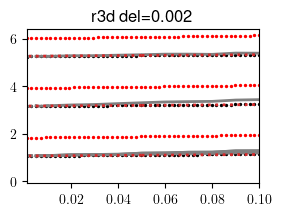

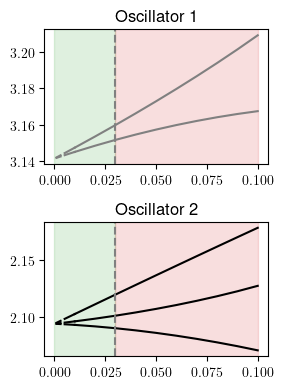

In [43]:
quick_plot_combined(a23_p002,
                    kw_f={'data_list':data_p002_list},
                    kw_r3d={'data_list':data_r3d_p002_list},
                    kw_r={'etup':etup23})

# del=0.0045

In [44]:
del23_p0045 = 0.0045
a23_p0045 = nm.nmCoupling(**kw_nm, del1=del23_p0045)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


## Get Branches Full

In [45]:
kw_p0045 = {'a':a23_p0045,'del1':del23_p0045,'recompute':False,
            'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [46]:
data_p0045_list = []

In [47]:
in_dicts = [dict(init=0,eps_init=0.01,eps_final=0.024,deps=.0005),
            dict(init=0,eps_init=0.01,eps_final=0.0005,deps=-.0005)]

In [48]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0045)
    data_p0045_list.append(dat)
fname = kw_p0045['bifdir']+'hyper_gw2_23_p0045.txt'

fname1 td_branch_init=0_nm=23_del=0.0045_ei=0.01_ef=0.024_de=0.0005.txt
fname2 ts_branch_init=0_nm=23_del=0.0045_ei=0.01_ef=0.024_de=0.0005.txt
fname1 td_branch_init=0_nm=23_del=0.0045_ei=0.01_ef=0.0005_de=-0.0005.txt
fname2 ts_branch_init=0_nm=23_del=0.0045_ei=0.01_ef=0.0005_de=-0.0005.txt


In [49]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [50]:
data_r3d_p0045_list = []

In [51]:
# find init for this branch
_,init = phase_lock_r3d([1,0,0],a23_p0045,.02,_redu_3dc)
print(init)

t_diff 1.32885445604349672, Y=[ 1.32885446 -0.02816272 -0.01894271]                                              
[ 1.3289 -0.0282 -0.0189]


In [52]:
# bot 1f
dat = follow_locking_3d(init,a23_p0045,(.02,.085,.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0045_list.append(dat)

In [53]:
# bot 1b
dat = follow_locking_3d(init,a23_p0045,(.02,.001,-.001),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0045_list.append(dat)

In [54]:
# find init for this branch
_,init = phase_lock_r3d([3,0,0],a23_p0045,.02,_redu_3dc)

t_diff 3.44032533687014740, Y=[ 3.44032534 -0.02826838 -0.01903313]                                              


In [55]:
# top 1f
dat = follow_locking_3d(init,a23_p0045,(.02,.082,.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0045_list.append(dat)

In [56]:
# top 1b
dat = follow_locking_3d(init,a23_p0045,(.02,.001,-.001),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0045_list.append(dat)

In [57]:
# find init for this branch
_,init = phase_lock_r3d([5,0,0],a23_p0045,.02,_redu_3dc)

t_diff 5.53546963655893911, Y=[ 5.53546964 -0.02815653 -0.01901474]                                              


In [58]:
# top 1f
dat = follow_locking_3d(init,a23_p0045,(.02,.1,.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0045_list.append(dat)

In [59]:
# top 1b
dat = follow_locking_3d(init,a23_p0045,(.02,.001,-.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0045_list.append(dat)

## Plot

eps_min 0.01800000000000001


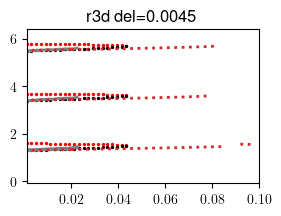

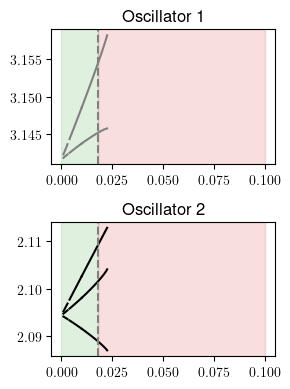

In [60]:
quick_plot_combined(a23_p0045,
                    kw_f={'data_list':data_p0045_list},
                    kw_r3d={'data_list':data_r3d_p0045_list},
                    kw_r={'etup':etup23})

# del=0.0047

In [61]:
del23_p0047 = 0.0047
a23_p0047 = nm.nmCoupling(**kw_nm, del1=del23_p0047)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


## Get Branches Full

In [62]:
kw_p0047 = {'a':a23_p0047,'del1':del23_p0047,'recompute':False,
            'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [63]:
data_p0047_list = []

In [64]:
in_dicts = [dict(init=0,eps_init=0.005,eps_final=0.00935,deps=.0005),
            dict(init=0,eps_init=0.005,eps_final=0.0005,deps=-.0005)]

In [65]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0047)
    data_p0047_list.append(dat)
fname = kw_p0047['bifdir']+'hyper_gw2_23_p0047.txt'

fname1 td_branch_init=0_nm=23_del=0.0047_ei=0.005_ef=0.00935_de=0.0005.txt
fname2 ts_branch_init=0_nm=23_del=0.0047_ei=0.005_ef=0.00935_de=0.0005.txt
fname1 td_branch_init=0_nm=23_del=0.0047_ei=0.005_ef=0.0005_de=-0.0005.txt
fname2 ts_branch_init=0_nm=23_del=0.0047_ei=0.005_ef=0.0005_de=-0.0005.txt


In [66]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [67]:
data_r3d_p0047_list = []

In [68]:
# find init for this branch
_,init = phase_lock_r3d([1,0,0],a23_p0047,.02,_redu_3dc)
print(init)

t_diff 1.37321294665175338, Y=[ 1.37321295 -0.02869336 -0.01906103]                                              
[ 1.3732 -0.0287 -0.0191]


In [69]:
# bot 1f
dat = follow_locking_3d(init,a23_p0047,(.02,.1,.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0047_list.append(dat)

In [70]:
# bot 1b
dat = follow_locking_3d(init,a23_p0047,(.02,.001,-.001),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0047_list.append(dat)

In [71]:
# find init for this branch
_,init = phase_lock_r3d([3,0,0],a23_p0047,.02,_redu_3dc)

t_diff 3.49804229594998509, Y=[ 3.4980423  -0.02879117 -0.01914304]                                              


In [72]:
# top 1f
dat = follow_locking_3d(init,a23_p0047,(.02,.034,.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0047_list.append(dat)

In [73]:
# top 1b
dat = follow_locking_3d(init,a23_p0047,(.02,.001,-.001),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0047_list.append(dat)

In [74]:
# find init for this branch
_,init = phase_lock_r3d([5,0,0],a23_p0047,.02,_redu_3dc)

t_diff 5.58678819523244112, Y=[ 5.5867882  -0.02866751 -0.01911321]                                              


In [75]:
# top 1f
dat = follow_locking_3d(init,a23_p0047,(.02,.042,.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0047_list.append(dat)

In [76]:
# top 1b
dat = follow_locking_3d(init,a23_p0047,(.02,.001,-.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0047_list.append(dat)

## Plot

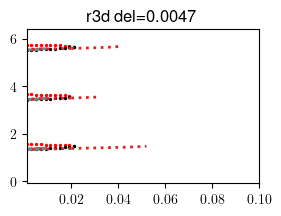

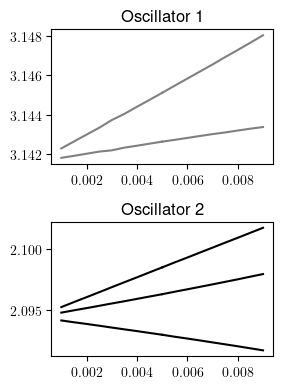

In [77]:
quick_plot_combined(a23_p0047,
                    kw_f={'data_list':data_p0047_list},
                    kw_r3d={'data_list':data_r3d_p0047_list},
                    kw_r={'etup':etup23})

## Integrate Reduced Check

In [78]:
# multiple initial conditions
init_phases23_p0047 = np.linspace(0,2*np.pi,6,endpoint=False)
t3d_p0047 = np.arange(0,5000,.01)

sols_3d = []
sols_1d = []

for i in range(len(init_phases23_p0047)):
    sol3d_p0047 = solve_ivp(_redu_3dc,[0,t3d_p0047[-1]],
                           [init_phases23_p0047[i],0,0],
                           args=(a23_p0047,.05),t_eval=t3d_p0047)
    
    # sol1d_p0047 = solve_ivp(_redu_c,[0,t3d_p0047[-1]],
    #                        [init_phases23_p0047[i]],
    #                        args=(a23_p0047,.05),t_eval=t3d_p0047)
    
    sols_3d.append(sol3d_p0047)
    # sols_1d.append(sol1d_p0047)

phase 0.0 [ 1.45177655 -0.07290472 -0.04820497]
phase 1.0471975511965976 [ 1.45220823 -0.07290029 -0.04821176]
phase 2.0943951023931953 [ 5.29746134 -0.07894384 -0.0433676 ]
phase 3.141592653589793 [ 5.50385268 -0.0743624  -0.04735249]
phase 4.1887902047863905 [ 5.75243485 -0.07296962 -0.04783124]
phase 5.235987755982988 [ 5.7817532  -0.07308971 -0.04761278]


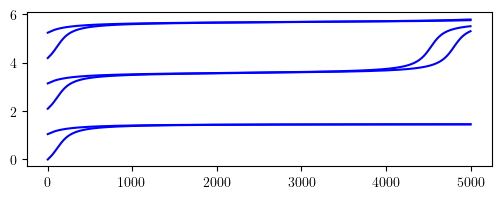

In [79]:
fig,axs = plt.subplots(figsize=(6,2))
for i in range(len(init_phases23_p0047)):
    axs.plot(t3d_p0047,sols_3d[i].y[0],color='blue')
    # axs.plot(t3d_p0047,sols_1d[i].y[0],color='red')
    print('phase',init_phases23_p0047[i],sols_3d[i].y.T[-1,:])